## Code to work with ATM data along the flowline of Zachariae Isstrom

**by Jukes Liu**

**June 2019 ICESat-2 Hackweek**


In [2]:
#IMPORT PACKAGES
import os
import glob
import pandas as pd
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
import pyproj
import geopandas as gpd
from shapely.geometry import Point, Polygon
from ipyleaflet import Map, Marker, basemaps #'OpenTopoMap'
import cartopy

/srv/conda/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/srv/conda/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Read in ATM elevation CSV files into dataframes and each variable into 1D arrays:

In [17]:
#get all the relevant csv files as a list and sort in order of the flight path
#filelist = glob.glob("../data/ILATM2_2018*.csv")
filelist = glob.glob("../data_raw/ATM_2014/*.csv")
filelist.sort(reverse=True)

#test with first file in the filelist
# filelist = [filelist[0]] 

#create an empty DataFrame to hold the stitched together ATM data along the profile
df_total = pd.DataFrame()

#for each csv file
for file in filelist:
    #print(file)
    #read the csv file into a pandas DataFrame
    csv_df = pd.read_csv(file, skiprows=9)
    
    #concatenate (join) it to the df_total
    df_total = pd.concat([csv_df, df_total])

#check that we have all the data properly stitched together:
#print(df_total)

#Read variables from csv DataFrame into 1D arrays
ATM_lat = df_total.loc[:, df_total.keys()[1]].values
ATM_long = df_total.loc[:, df_total.keys()[2]].values
ATM_elev = df_total.loc[:, df_total.keys()[3]].values
TrackID = df_total.loc[:, df_total.keys()[-1]].values
NS_slope = df_total.loc[:,df_total.keys()[4]].values
EW_slope = df_total.loc[:,df_total.keys()[5]].values

#Set in new DataFrame called ATM_data
ATM_data = pd.DataFrame([ATM_lat, ATM_long, ATM_elev, TrackID, NS_slope, EW_slope])
headers = ['lat', "lon", "elev", "TrackID", "NS_slope", "EW_slope"]
ATM_data = ATM_data.transpose()
ATM_data.columns = headers
#ATM_data.head()

#Select only the data with TrackID 0:
ATM_track0 = ATM_data[ATM_data['TrackID'] == 0.0].copy()

#Reverse order for 2014 data:
ATM_track0 = ATM_track0.sort_index(ascending=False)

#get the variables in arrays:
track0_lat = ATM_track0.lat.values
track0_long = ATM_track0.lon.values
track0_elev = ATM_track0.elev.values
track0_slope_NS = ATM_track0.NS_slope.values
track0_slope_EW = ATM_track0.EW_slope.values

ATM_track0.head()

,lat,lon,elev,TrackID,NS_slope,EW_slope
18550,79.150302,335.663786,883.1842,0.0,-0.006359,-0.009239
18546,79.150190,335.665218,883.0373,0.0,-0.005456,-0.006168
18542,79.150078,335.666651,882.8962,0.0,-0.003837,-0.006896
18538,79.149967,335.668086,882.7560,0.0,-0.004822,-0.005571
18534,79.149855,335.669519,882.5889,0.0,-0.003373,-0.009250


## Reproject lat and long into Greenland Polar Stereo coordinates (ESPG: 3413)

In [18]:
#Coordinate transformation function written by Fernando Paolo:
def transform_coord(proj1, proj2, x, y):
    """
    Transform coordinates from proj1 to proj2 (EPSG num).

    Example EPSG projs:
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    """
    # Set full EPSG projection strings
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert

#use the function to transform into Greenland Polar Stereo (PS_x, PS_y)
PS_x, PS_y = transform_coord(4326, 3413, track0_long, track0_lat)
print(PS_x)
print(PS_y)

[415944.31738589 415976.20023373 416008.10264363 ... 527344.24307394
 527329.11751696 527314.0468452 ]
[-1102872.34885821 -1102873.40305985 -1102874.44909802 ...
 -1047840.32290794 -1047810.99688281 -1047781.64325332]


## Calculate distance along the flowline:

### For 2018:

In [6]:
#create an empty array to contain the distance along flow 
dist_along = np.empty(len(track0_lat), dtype=float)

#for each lat-long point:
for i in range(len(track0_lat)):
    #for the first point, set distance along flow to 0 m
    if i == 0:
        dist_along[i] = 0.0
    
    #for all other subsequent points:
    else:
        #calculate distance from the last point in meters
        x_diff = PS_x[i] - PS_x[i-1]
        y_diff = PS_y[i] - PS_y[i-1]
                
        #calculate distance from the previous point using the distance formula:    
        dist_last = math.sqrt(((x_diff)**2)+((y_diff)**2))
        #print(dist_last)
        
        #add it to the previous distance along the track to get the cumulative distance
        dist_along[i] = dist_last + dist_along[i-1]

    #check the array of distance along the track in meters:
    #print(dist_along[i], ATM_elev[i])

### For 2014, we must calculate as distance from the \2018\ start point

Start point of ATM 2018 Profile in PS: 
397916.203061, -1.102322e+06

In [19]:
#create an empty array to contain the distance along flow 
dist_along = np.empty(len(track0_lat), dtype=float)

#for each lat-long point:
for i in range(len(track0_lat)):
    #for the first point, set distance along flow to 0 m
    if i == 0:
        x_from2018 = PS_x[i] - 397916.203061
        y_from2018 = PS_y[i] - (-1.102322e+06)
        
        dist_along[i] = math.sqrt(((x_from2018)**2)+((y_from2018)**2))
        print(dist_along[i])
        
    #for all other subsequent points:
    else:
        #calculate distance from the last point in meters
        x_diff = PS_x[i] - PS_x[i-1]
        y_diff = PS_y[i] - PS_y[i-1]
                
        #calculate distance from the previous point using the distance formula:    
        dist_last = math.sqrt(((x_diff)**2)+((y_diff)**2))
        #print(dist_last)
        
        #add it to the previous distance along the track to get the cumulative distance
        dist_along[i] = dist_last + dist_along[i-1]

    #check the array of distance along the track in meters:
    #print(dist_along[i], ATM_elev[i])

18036.512688908148


## Final data extracted into arrays
+ ATM_long: longitude of elev points
+ ATM_lat: latitude of elev points
+ PS_x: x-coords of elev points in Greenland Polar Stereo
+ PS_y: y-coords of elev points in Greenland Polar Stereo
+ ATM_elev: elevation points with z in meters
+ dist_along: distance along the flowline in meters

## ...and recombined into a dataframe called final_data:

In [20]:
variables = [track0_lat, track0_long, PS_x, PS_y, track0_elev, dist_along, track0_slope_NS, track0_slope_EW]
indices = ['ATM_lat', "ATM_long", "PS_x", "PS_y", "ATM_elev", "dist_along", 'slope_NS', 'slope_EW']

#create DataFrame from these variables
final_data = pd.DataFrame(variables)
final_data = final_data.transpose()
final_data.columns = indices
final_data.head()

,ATM_lat,ATM_long,PS_x,PS_y,ATM_elev,dist_along,slope_NS,slope_EW
0,79.150302,335.663786,415944.317386,-1.102872e+06,883.1842,18036.512689,-0.006359,-0.009239
1,79.150190,335.665218,415976.200234,-1.102873e+06,883.0373,18068.412960,-0.005456,-0.006168
2,79.150078,335.666651,416008.102644,-1.102874e+06,882.8962,18100.332515,-0.003837,-0.006896
3,79.149967,335.668086,416040.005299,-1.102875e+06,882.7560,18132.248675,-0.004822,-0.005571
4,79.149855,335.669519,416071.908333,-1.102876e+06,882.5889,18164.168794,-0.003373,-0.009250


In [15]:
# final_data_2018 = final_data.copy()
final_data_2018.head()

,ATM_lat,ATM_long,PS_x,PS_y,ATM_elev,dist_along,slope_NS,slope_EW
0,79.212155,334.848567,397916.203061,-1.102322e+06,891.6397,0.000000,0.002528,-0.003607
1,79.212039,334.850146,397950.884957,-1.102323e+06,891.4861,34.695014,0.003011,-0.003841
2,79.211923,334.851724,397985.547970,-1.102324e+06,891.3228,69.371314,0.003946,-0.003423
3,79.211808,334.853304,398020.212712,-1.102325e+06,891.1725,104.046285,0.004970,-0.002393
4,79.211692,334.854884,398054.914911,-1.102326e+06,891.0138,138.761317,0.005104,-0.003135


In [22]:
final_data_2014 = final_data.copy()
final_data_2014.head()

,ATM_lat,ATM_long,PS_x,PS_y,ATM_elev,dist_along,slope_NS,slope_EW
0,79.150302,335.663786,415944.317386,-1.102872e+06,883.1842,18036.512689,-0.006359,-0.009239
1,79.150190,335.665218,415976.200234,-1.102873e+06,883.0373,18068.412960,-0.005456,-0.006168
2,79.150078,335.666651,416008.102644,-1.102874e+06,882.8962,18100.332515,-0.003837,-0.006896
3,79.149967,335.668086,416040.005299,-1.102875e+06,882.7560,18132.248675,-0.004822,-0.005571
4,79.149855,335.669519,416071.908333,-1.102876e+06,882.5889,18164.168794,-0.003373,-0.009250


In [403]:
#SAVE TO CSV
final_data.to_csv('/home/jovyan/xtrak/data_prod/ATMprof_20140429.csv',index=False)

## Convert to GeoDataFrame

In [8]:
#create new geometry column:
final_data['geometry'] = list(zip(final_data['PS_x'], final_data['PS_y']))

#create new shapely Point geometry objects 
final_data['geometry'] = final_data['geometry'].apply(Point)
#final_data.head()

#convert DataFrame to GeoDataFrame in Polar Stereo
final_gdf = gpd.GeoDataFrame(final_data, crs={'init' :'epsg:3413'})

final_gdf.head()

,ATM_lat,ATM_long,PS_x,PS_y,ATM_elev,dist_along,slope_NS,slope_EW,geometry
0,79.212155,334.848567,397916.203061,-1.102322e+06,891.6397,0.000000,0.002528,-0.003607,POINT (397916.2030612105 -1102322.114924406)
1,79.212039,334.850146,397950.884957,-1.102323e+06,891.4861,34.695014,0.003011,-0.003841,POINT (397950.8849572688 -1102323.068921348)
2,79.211923,334.851724,397985.547970,-1.102324e+06,891.3228,69.371314,0.003946,-0.003423,POINT (397985.547969724 -1102324.028792245)
3,79.211808,334.853304,398020.212712,-1.102325e+06,891.1725,104.046285,0.004970,-0.002393,POINT (398020.2127118901 -1102324.870937772)
4,79.211692,334.854884,398054.914911,-1.102326e+06,891.0138,138.761317,0.005104,-0.003135,POINT (398054.9149109663 -1102325.814771683)


## Plotting the data:

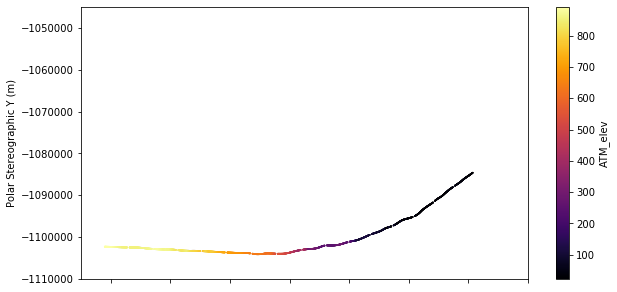

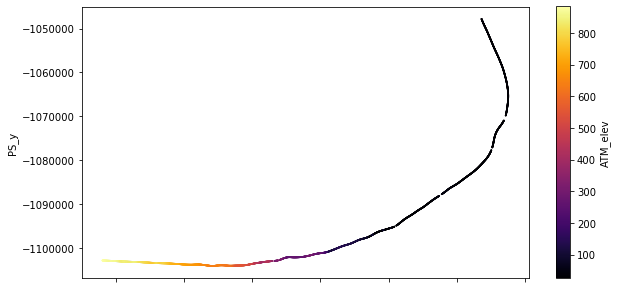

In [40]:
#2D elevation cross-section plot with DataFrame:
# elev_prof = final_data_2018.plot(x='dist_along', y='ATM_elev', figsize=(10, 5))
# final_data_2014.plot(x = 'dist_along', y = 'ATM_elev', c = 'r', ax=elev_prof, figsize=(10, 5))
# elev_prof.set_xlabel("Distance along glacier flowline (m)")
# elev_prof.set_ylabel("WGS84 Ellipsoid Height (m)")
# elev_prof.set_xlim([0,150000])
# elev_prof.legend(["2018-04-18", "2014-04-29"])
# plt.savefig("/home/jovyan/xtrak/figures/ATM_profiles.png")


#2D plot of track (X, Y, by elevation) with DataFrame:
track = final_data_2018.plot(x='PS_x', y='PS_y', kind='scatter', s=0.5, c='ATM_elev', cmap='inferno', figsize=(10, 5))
track.set_xlabel("Polar Stereographic X (m)")
track.set_ylabel("Polar Stereographic Y (m)")
track.set_ylim([-1110000, -1045000])
track.set_xlim([390000,540000])
final_data_2014.plot(x='PS_x', y='PS_y', kind='scatter', s=0.5, c='ATM_elev', cmap='inferno', figsize=(10, 5))

# plt.savefig("/home/jovyan/xtrak/figures/ATMtracks.png")

#plot with GeoDataFrame
# gdf_plot = final_gdf.plot('ATM_elev', s=0.05, cmap='inferno', legend=True);
# gdf_plot.set_xlabel("Polar Stereographic X (m)")
# gdf_plot.set_ylabel("Polar Stereographic Y (m)")

## Playing around with slope:

In [280]:
elev_prof = final_data.plot(x='dist_along', y='ATM_elev', figsize=(10, 5), kind='scatter', s=0.5, c='slope_NS', vmin=-0.15, vmax=0.15, cmap='inferno')
elev_prof.set_xlabel("Distance along glacier flowline (m)")
elev_prof.set_ylabel("WGS84 Ellipsoid Height (m)")

#3D plot with dataframe
# from mpl_toolkits.mplot3d import Axes3D
# f = plt.figure()
# ax3D = f.add_subplot(111, projection='3d')
# sc = ax3D.scatter(final_data['PS_x'], final_data['PS_y'], final_data['ATM_elev'], c=final_data['slope_NS'], s=1, cmap='inferno', vmin=-0.15, vmax=0.15)
# plt.colorbar(sc)
# plt.show()

/srv/conda/lib/python3.6/site-packages/pandas/plotting/_core.py:304: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


FigureCanvasNbAgg()

Text(0, 0.5, 'WGS84 Ellipsoid Height (m)')